# Dataset source
https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images?resource=download-directory

# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(333)

%matplotlib inline
sns.set_theme(style="white")
plt.style.use('dark_background')
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 250

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# fixing results
random.seed(42) 
np.random.seed(42)
tf.random.set_seed(42)

# Data Wrangling

In [2]:
my_data_dir = 'chest_xray/'
my_data_dir

'chest_xray/'

In [3]:
os.listdir(my_data_dir)

['test', 'train']

In [4]:
test_path = os.path.join(my_data_dir, 'test')
train_path = os.path.join(my_data_dir, 'train')

In [5]:
test_path

'chest_xray/test'

In [6]:
os.listdir(test_path)

['NORMAL', 'PNEUMONIA']

In [7]:
os.listdir(train_path)

['NORMAL', 'PNEUMONIA']

# Data Visualization

## PNEUMONIA

In [8]:
pneumonia = os.listdir(os.path.join(train_path, "PNEUMONIA"))

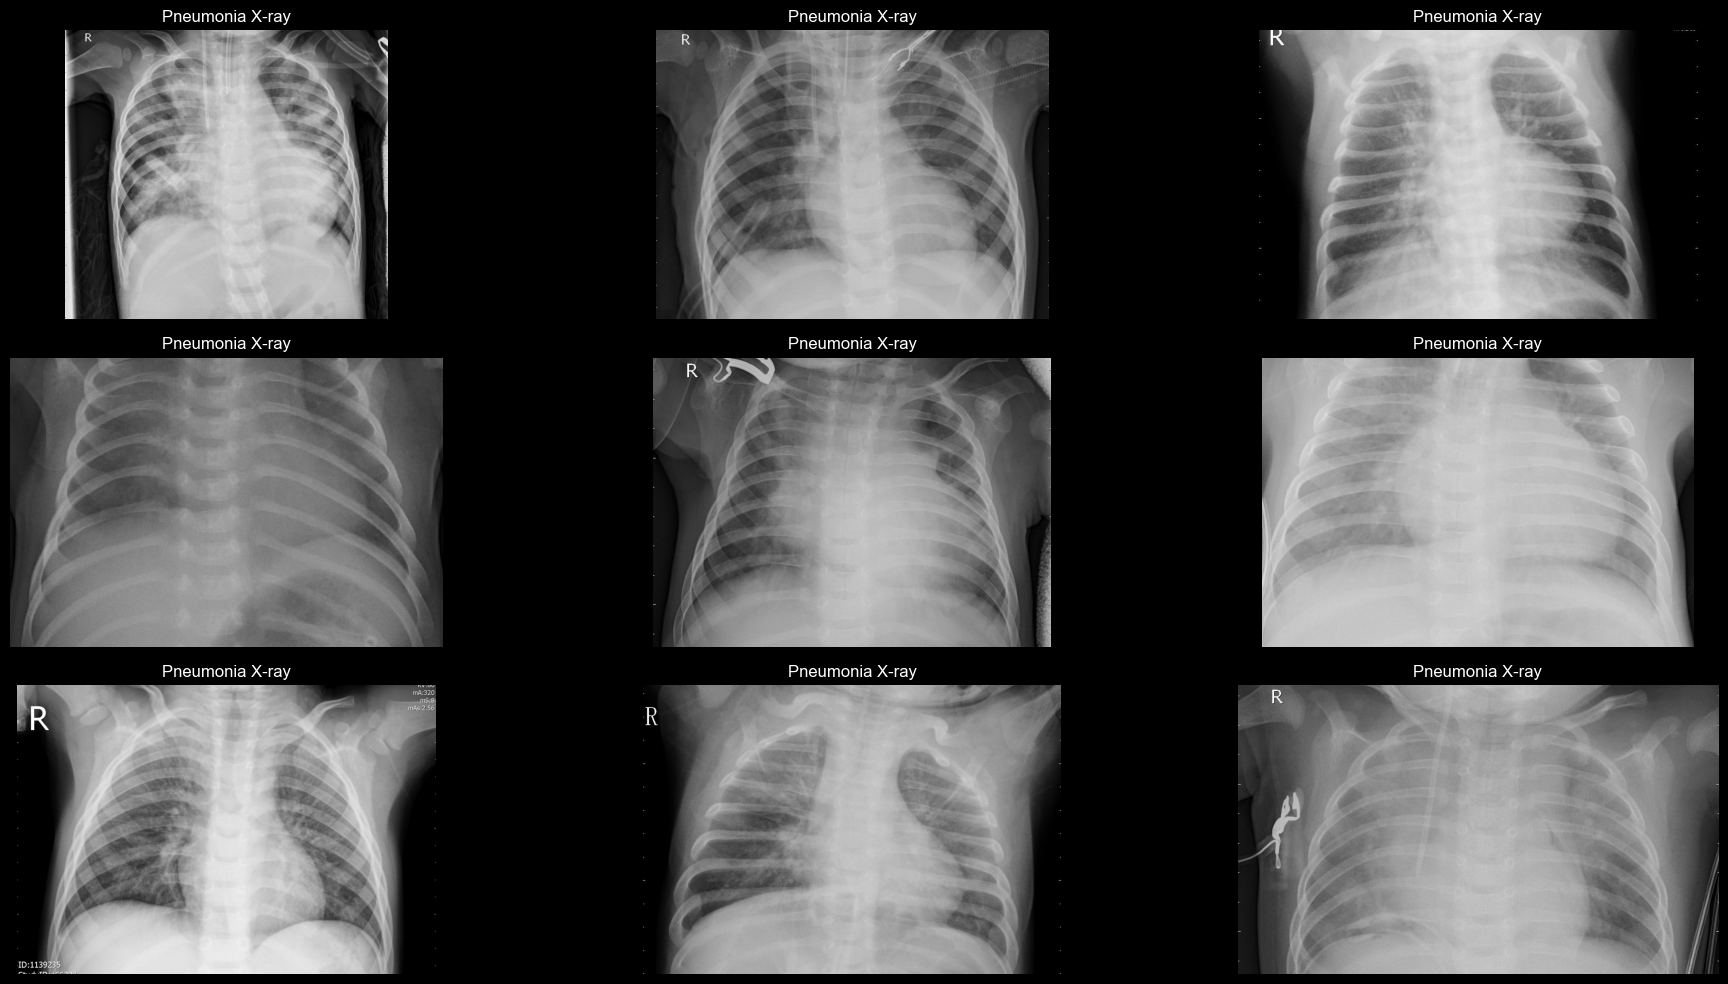

In [9]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(train_path,'PNEUMONIA', pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [10]:
len(os.listdir(os.path.join(train_path, "PNEUMONIA")))

3883

## NORMAL

In [11]:
normal = os.listdir(os.path.join(train_path, "NORMAL"))

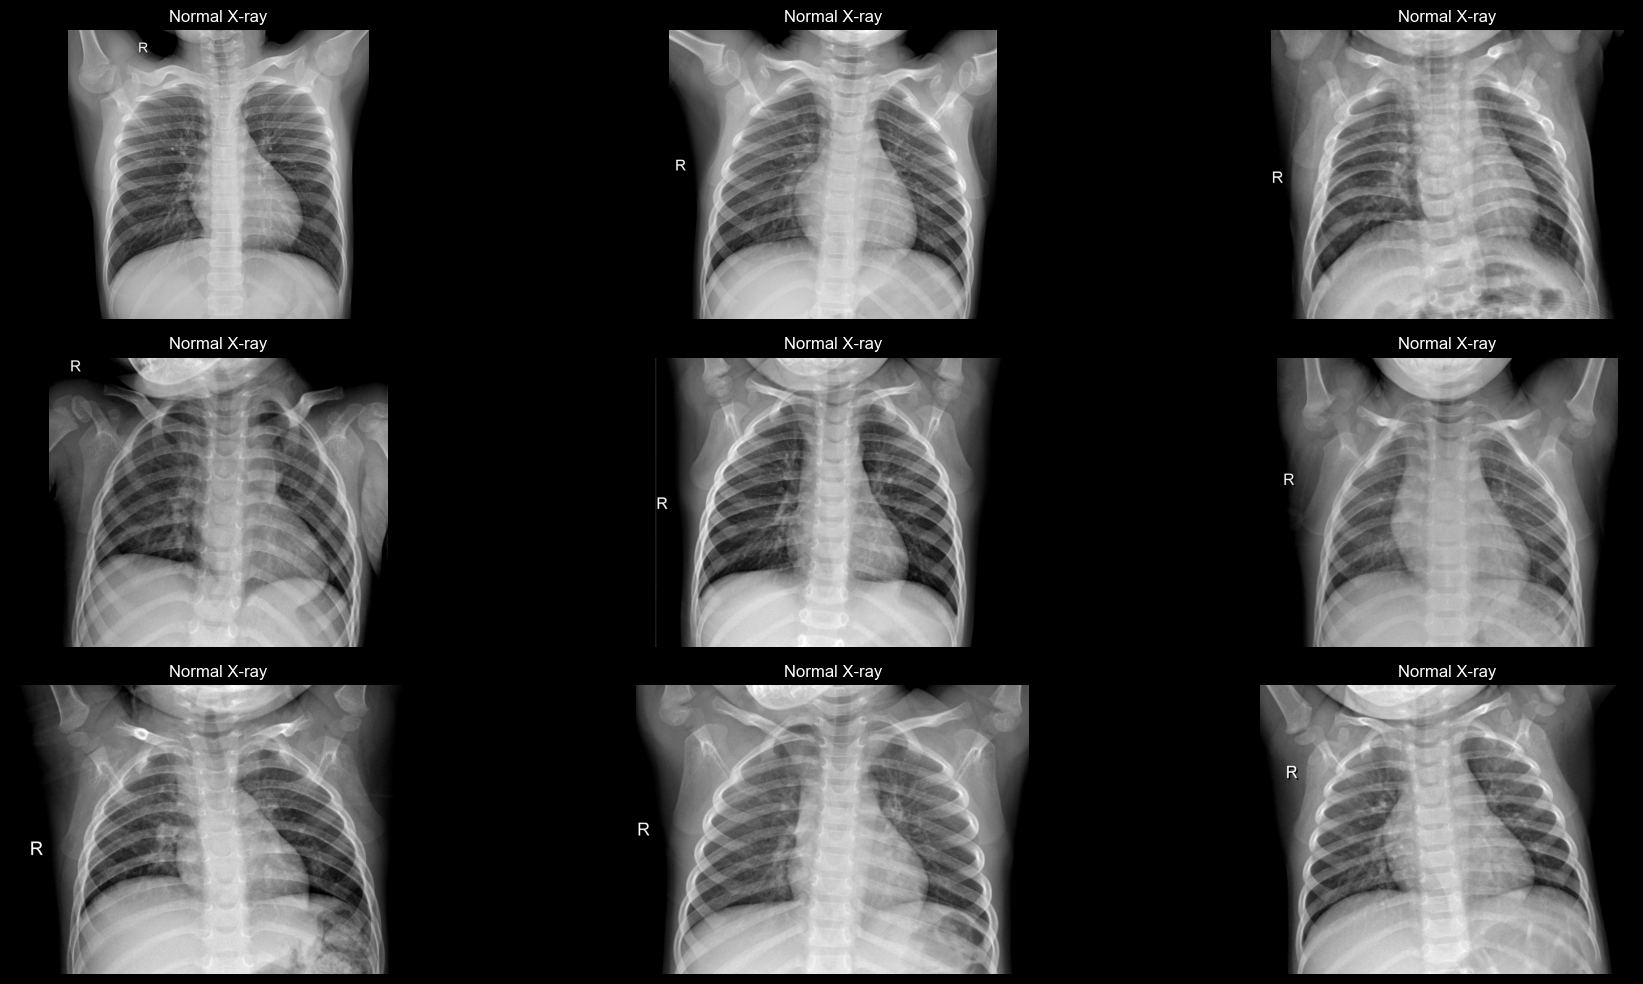

In [12]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(train_path,'NORMAL', normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

In [13]:
os.listdir(os.path.join(train_path, "PNEUMONIA"))[100]

'BACTERIA-1355733-0001.jpeg'

In [14]:
len(os.listdir(os.path.join(train_path, "NORMAL")))

1349

In [15]:
# checking pictures size
dim1 = []
dim2 = []
for image_filename in os.listdir(os.path.join(test_path, "NORMAL")):
    img = imread(os.path.join(test_path, "NORMAL", image_filename))
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

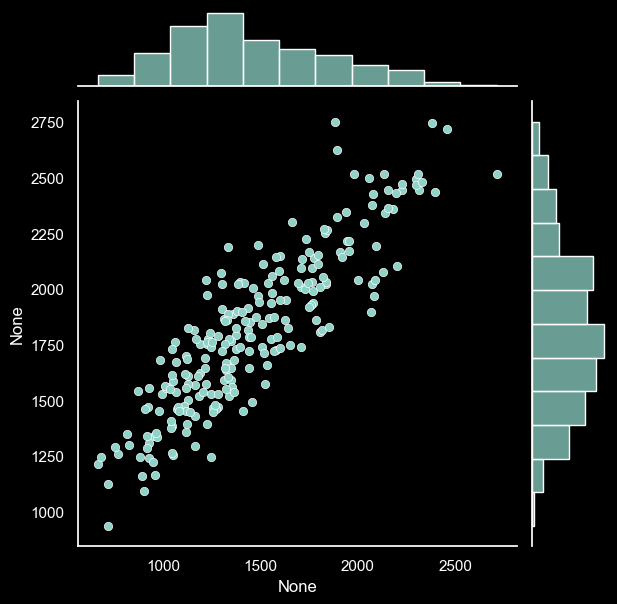

In [16]:
sns.jointplot(x=dim1, y=dim2);

In [17]:
np.mean(dim1), np.mean(dim2)

(1455.931623931624, 1815.2649572649573)

*Se establece el tamaño de todas las imágenes a 256x256 para que no sea tan pesado el procesamiento*

In [18]:
image_shape = (256, 256, 3)

# Data Augmentation

*We perturb the images to create new training records*

In [19]:
image_gen = ImageDataGenerator(
                                rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                rescale=1/255,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                shear_range=0.2
                              )

*Given the way the data is stored, flow_from_directory can be used*

In [20]:
image_gen.flow_from_directory(train_path)

Found 5232 images belonging to 2 classes.


In [21]:
image_gen.flow_from_directory(test_path)

Found 624 images belonging to 2 classes.


In [22]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode= 'rgb',
                                                batch_size= 16,
                                                class_mode='binary',
                                                shuffle=True)

Found 5232 images belonging to 2 classes.


In [23]:
len(train_image_gen.classes)

5232

In [24]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',
                                               shuffle=False)

Found 624 images belonging to 2 classes.


In [25]:
len(test_image_gen.classes)

624

In [26]:
train_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# CNN design

*Other architectures were tested, many failed due to OOM and of those that worked, the one with the best performance was the following*

In [27]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu',))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu',))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 238144)            0

# Training the model

In [29]:
%%time
results = model.fit_generator(train_image_gen, epochs=20, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/20
327/327 [==============================] - 260s 762ms/step - loss: 0.3604 - accuracy: 0.8394 - val_loss: 0.4203 - val_accuracy: 0.8606
Epoch 2/20
327/327 [==============================] - 180s 549ms/step - loss: 0.3487 - accuracy: 0.8417 - val_loss: 0.5009 - val_accuracy: 0.7324
Epoch 3/20
327/327 [==============================] - 166s 507ms/step - loss: 0.3185 - accuracy: 0.8654 - val_loss: 0.4285 - val_accuracy: 0.7837
Epoch 4/20
327/327 [==============================] - 177s 541ms/step - loss: 0.2911 - accuracy: 0.8735 - val_loss: 0.3451 - val_accuracy: 0.8590
Epoch 5/20
327/327 [==============================] - 190s 580ms/step - loss: 0.2483 - accuracy: 0.9000 - val_loss: 0.4169 - val_accuracy: 0.8381
Epoch 6/20
327/327 [==============================] - 197s 602ms/step - loss: 0.2474 - accuracy: 0.8941 - val_loss: 0.3261 - val_accuracy: 0.8670
Epoch 7/20
327/327 [==============================] - 197s 602ms/step - loss: 0.2468 - accuracy: 0.9008 - val_loss: 0.3866 -

In [30]:
model.save("mod_pneumonia1.h5")

# Model Evaluation

In [31]:
#model = load_model("mod_pneumonia1.h5")

In [32]:
print(model.metrics_names)
model.evaluate_generator(test_image_gen)

['loss', 'accuracy']


[0.3334219753742218, 0.8653846383094788]

In [33]:
pred_probabilities = model.predict_generator(test_image_gen)
pred_probabilities

array([[1.46898389e-01],
       [5.20779431e-01],
       [3.95022601e-01],
       [9.98327911e-01],
       [4.71660048e-01],
       [5.94088197e-01],
       [5.05887270e-01],
       [3.33940319e-04],
       [1.59140602e-01],
       [3.19453239e-01],
       [2.11169738e-02],
       [3.05587798e-01],
       [7.32526839e-01],
       [3.70277405e-01],
       [7.40817413e-02],
       [7.30748832e-01],
       [5.00926672e-06],
       [3.85775656e-01],
       [1.45981416e-01],
       [2.51330584e-01],
       [3.77616197e-01],
       [8.61916840e-01],
       [7.69889891e-01],
       [9.66679990e-01],
       [2.91368961e-01],
       [2.18820155e-01],
       [1.37572214e-01],
       [2.15040147e-01],
       [4.27844942e-01],
       [4.38165180e-02],
       [6.66001737e-01],
       [7.02188730e-01],
       [1.07325174e-01],
       [5.40197790e-01],
       [1.63060620e-01],
       [2.84365356e-01],
       [7.66660422e-02],
       [3.21766470e-06],
       [3.11978366e-02],
       [2.35035270e-02],


In [34]:
predictions = pred_probabilities > 0.5

In [35]:
confusion_matrix(test_image_gen.classes, predictions)

array([[156,  78],
       [  8, 382]], dtype=int64)

In [36]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.67      0.78       234
           1       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.86       624



# Interpretation

The model has a high precision for the normal class (95%) and a high recall for the pneumonia class (98%), suggesting it is a robust model for classifying chest radiographs. This high precision for the normal class also indicates that it **is rare for the model to have false positives**, meaning it is unlikely to incorrectly identify a normal image as having pneumonia. However, the recall for the normal class (67%) is relatively low, meaning the model is missing some normal cases. This could be an area for improvement in future iterations of the model.